# Mid-Term Project: A Unifying RL Algorithm
**Author:** Harshal Dafade  
**Course:** COMP4240/5435 - Reinforcement Learning  
**Instructor:** Reza Azadeh  
**Date:** 10/30/2024

In [45]:
#imports

In [139]:

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


In [140]:
#n-step SARSA

In [141]:

def epsilon_greedy_policy(Q, state, epsilon, nA):
    if np.random.rand() > epsilon:
        max_actions = np.flatnonzero(Q[state] == Q[state].max())
        return np.random.choice(max_actions)
    else:
        return np.random.choice(nA)

def n_step_sarsa(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, decay_factor, n):
    Q = np.zeros((env.observation_space.n, env.action_space.n)) 
    episode_rewards = np.zeros(num_episodes)
    
    for episode in range(num_episodes):
        epsilon = max(epsilon_min, epsilon_start * (decay_factor ** episode))  
        state, _ = env.reset()  
        action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)
        T = np.inf  
        t = 0  
        tau = 0  
        rewards = []  
        states = [state]  
        actions = [action]  
        while tau < (T - 1):
            if t < T:
                next_state, reward, done, _, _ = env.step(action)
                rewards.append(reward)
                states.append(next_state)
                if done:
                    T = t + 1  
                else:
                    next_action = epsilon_greedy_policy(Q, next_state, epsilon, env.action_space.n)
                    actions.append(next_action)
            tau = t - n + 1  
            if tau >= 0:
                if n == 1:  
                    Q[states[tau], actions[tau]] += alpha * (rewards[tau] + gamma * Q[next_state].max() - Q[states[tau], actions[tau]])
                else:
                    G = np.sum([gamma**(i - tau - 1) * rewards[i] for i in range(tau + 1, min(tau + n, T))])
                    if tau + n < T:
                        G += gamma**n * Q[states[tau + n], actions[tau + n]]
                    Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])
            t += 1  
            state = next_state  
            action = next_action if 'next_action' in locals() else action  

        episode_rewards[episode] = np.sum(rewards)  

    return Q, episode_rewards



# Algorithm Overview
The n-step SARSA algorithm updates Q-values based on n-step returns, allowing for flexibility between one-step TD and Monte Carlo approaches.


# Implementation Details


- **`n_step_sarsa`**: This function implements the n-step SARSA algorithm.
- **`epsilon_greedy_policy`**: This function selects actions based on an epsilon-greedy policy.



## Cliff Walking Environment
The Cliff Walking environment requires an agent to cross a cliff without falling off.

- **State Space**: The state is represented by a grid layout.
- **Action Space**: Actions available include moving up, down, left, or right.
- **Reward Structure**: Rewards are given for moving, with penalties for falling off the cliff or reaching the goal.
- **Goal of the Task**: Success is defined as navigating to the goal while avoiding the cliff.

In [142]:


def plot_results(nstep_rewards):
    episodes = len(nstep_rewards[0])
    avg_nstep_rewards = np.mean(nstep_rewards, axis=0)  

    plt.figure(figsize=(10, 6))
    plt.plot(avg_nstep_rewards, label='n-step SARSA', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Sum of Rewards over Episodes for n-step SARSA')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(avg_nstep_rewards[300:], label='n-step SARSA', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Sum of Rewards over Episodes 300 to 500 for n-step SARSA')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_optimal_policy(Q):
    action_mapping = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    
    optimal_policy = np.empty((4, 12), dtype=str)
    
    for state in range(Q.shape[0]):
        row = state // 12
        col = state % 12
        best_action = np.argmax(Q[state])
        optimal_policy[row, col] = action_mapping[best_action]
    
    for row in optimal_policy:
        print(' '.join(row))

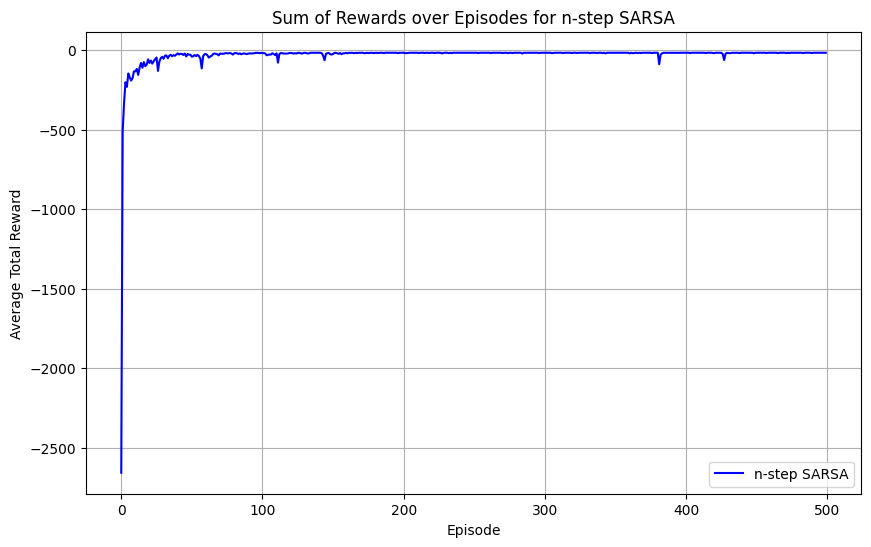

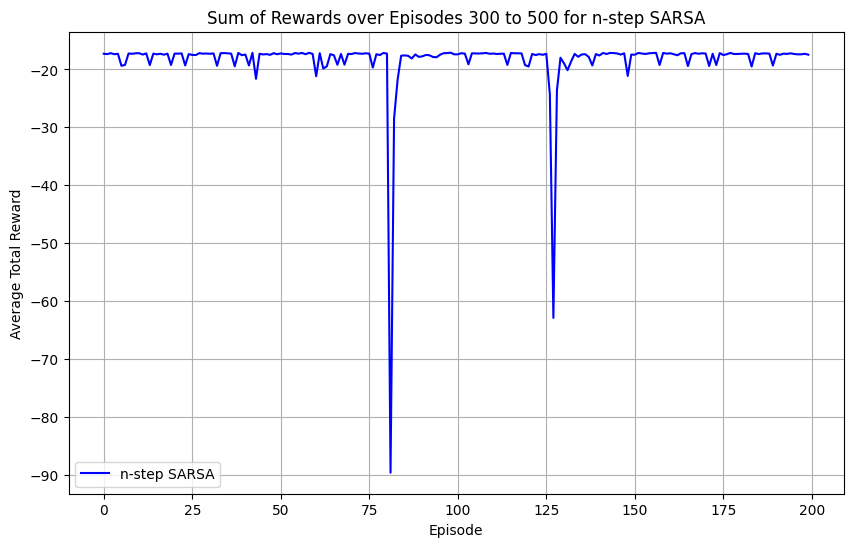

Optimal Policy (n-step SARSA):
R R R R R R R R R R R D
U U U U U U U U R R R D
U L U R U U U L U R R D
U U U U U U U U U U U U


In [143]:


def run_experiments_nstep():
    env = gym.make('CliffWalking-v0')
    num_runs = 50
    num_episodes = 500
    n = 3
    alpha = 0.1
    gamma = 0.99
    epsilon_start = 0.1
    epsilon_min = 0.01
    decay_factor = 0.99

    nstep_rewards = []
    final_q_nstep = None

    for _ in range(num_runs):
        Q_nstep, rewards = n_step_sarsa(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, decay_factor, n)
        
        nstep_rewards.append(rewards)
        final_q_nstep = Q_nstep

    plot_results(nstep_rewards)  
    env = gym.make('CliffWalking-v0', render_mode='human')  
    state, _ = env.reset()
    
    for _ in range(num_episodes):
        action = np.argmax(final_q_nstep[state])  
        state, reward, done, _, _ = env.step(action)
        env.render()  
        if done:
            break
    
    env.close()  
    print("Optimal Policy (n-step SARSA):")
    print_optimal_policy(final_q_nstep)
run_experiments_nstep()


The n-step SARSA algorithm is tested in the Cliff Walking environment over 50 separate runs, each with 500 episodes. By avoiding cliffs that result in negative rewards, this configuration enables the agent to learn how to move through a grid. In order to balance bias and variance in updates, the n-step return is set to 3. Stable learning is ensured by a moderate learning rate of 0.1, and future rewards are highlighted by a discount factor of 0.99. Epsilon must be at least 0.01 to sustain some exploration, and it must begin at 0.1 to promote exploitation. In order to fine-tune the agent's policy, a gradual reduction in exploration is made possible by the decay factor of 0.99.

## Taxi Environment
The Taxi environment involves navigating a taxi to pick up and drop off passengers.

- **State Space**: The state is represented by the taxi's position, passenger location, and destination.
- **Action Space**: Available actions include moving south, north, east, west, picking up, and dropping off.
- **Reward Structure**: Rewards are given for successful drop-offs, with penalties for illegal actions.
- **Goal of the Task**: The objective is to maximize total rewards.

In [144]:


def plot_results(nstep_rewards):
    episodes = len(nstep_rewards[0])
    avg_nstep_rewards = np.mean(nstep_rewards, axis=0)  

    plt.figure(figsize=(10, 6))
    plt.plot(avg_nstep_rewards, label='n-step SARSA', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Sum of Rewards over Episodes for n-step SARSA in Taxi Environment')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(avg_nstep_rewards[300:], label='n-step SARSA', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Sum of Rewards over Episodes 300 to 500 for n-step SARSA in Taxi Environment')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_optimal_policy(Q):
    action_mapping = {0: 'S', 1: 'N', 2: 'E', 3: 'W', 4: 'P', 5: 'D'} 

    print("Optimal Policy (Taxi Position, Passenger Location, Destination):")
    
    for taxi_row in range(5):
        for taxi_col in range(5):
            for passenger_location in range(5):  
                for destination in range(4):  
                    state_index = (taxi_row * 5 + taxi_col) * 5 * 4 + passenger_location * 4 + destination
                    
                    best_action = np.argmax(Q[state_index])  
                    action_str = action_mapping[best_action]  
                    
                    print(f"Taxi at ({taxi_row}, {taxi_col}), Passenger Pos: {passenger_location}, Destination: {destination}, Best Action: {action_str}")








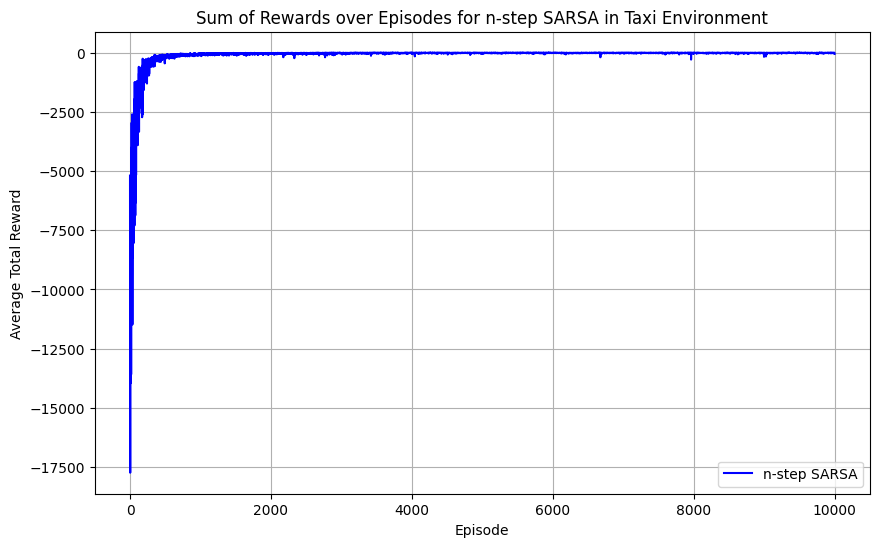

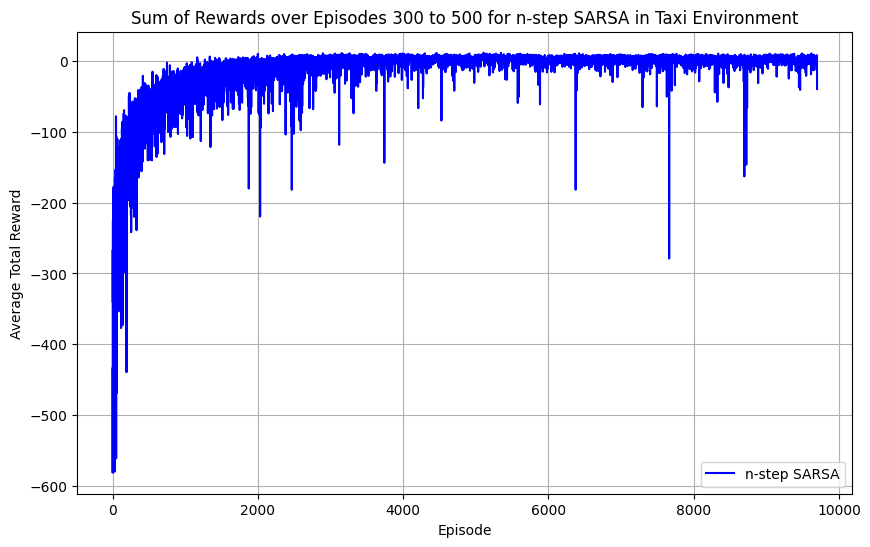

Optimal Policy (n-step SARSA):
Optimal Policy (Taxi Position, Passenger Location, Destination):
Taxi at (0, 0), Passenger Pos: 0, Destination: 0, Best Action: S
Taxi at (0, 0), Passenger Pos: 0, Destination: 1, Best Action: P
Taxi at (0, 0), Passenger Pos: 0, Destination: 2, Best Action: P
Taxi at (0, 0), Passenger Pos: 0, Destination: 3, Best Action: P
Taxi at (0, 0), Passenger Pos: 1, Destination: 0, Best Action: E
Taxi at (0, 0), Passenger Pos: 1, Destination: 1, Best Action: S
Taxi at (0, 0), Passenger Pos: 1, Destination: 2, Best Action: E
Taxi at (0, 0), Passenger Pos: 1, Destination: 3, Best Action: S
Taxi at (0, 0), Passenger Pos: 2, Destination: 0, Best Action: E
Taxi at (0, 0), Passenger Pos: 2, Destination: 1, Best Action: S
Taxi at (0, 0), Passenger Pos: 2, Destination: 2, Best Action: S
Taxi at (0, 0), Passenger Pos: 2, Destination: 3, Best Action: E
Taxi at (0, 0), Passenger Pos: 3, Destination: 0, Best Action: S
Taxi at (0, 0), Passenger Pos: 3, Destination: 1, Best Acti

In [145]:

def run_experiments_nstep():
    env = gym.make('Taxi-v3')  
    num_runs = 5
    num_episodes = 10000
    n = 5
    alpha = 0.2
    gamma = 0.99
    epsilon_start = 1.0  
    epsilon_min = 0.01
    decay_factor = 0.999  

    nstep_rewards = []
    final_q_nstep = None

    for _ in range(num_runs):
        Q_nstep, rewards = n_step_sarsa(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, decay_factor, n)
        
        nstep_rewards.append(rewards)
        final_q_nstep = Q_nstep

    plot_results(nstep_rewards)  

    env = gym.make('Taxi-v3', render_mode='human') 
    state, _ = env.reset()  

    for _ in range(num_episodes):
        action = np.argmax(final_q_nstep[state])  
        state, reward, done, truncated, _ = env.step(action)  
        env.render()  
        if done or truncated:
            break
    
    env.close()  
    print("Optimal Policy (n-step SARSA):")
    print_optimal_policy(final_q_nstep)

run_experiments_nstep()


The agent goes through five runs, each with 10,000 episodes, for the taxi environment. The agent learns how to pick up and drop off passengers efficiently thanks to this intensive training. The agent can use a combination of present and future rewards in its learning process because the n-step return is set to 5.
With a learning rate of 0.2, the agent's policy can be quickly modified. The significance of long-term rewards is highlighted by the discount factor which is 0.99. An epsilon of 1.0 at the beginning encourages exploration, while a minimum of 0.01 guarantees that some exploration will continue during training. With a decay factor of 0.999, the agent can gradually transition from exploration to exploitation, aiding strategy refinement.